In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
# from sklearn.model_selection import train_test_split
from verstack.stratified_continuous_split import scsplit

c:\Users\timcy\Anaconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
scan_1 = Image.open("C:/Users/timcy/Documents/Code/Personal/U-Net/data/scans/bjorke_1.png")
rs = 42
np.random.seed(rs)

In [3]:
import os

# Directory containing the scans
scans_dir = "C:/Users/timcy/Documents/Code/Personal/U-Net/data/scans/"
masks_dir = "C:/Users/timcy/Documents/Code/Personal/U-Net/data/masks/"

# List to store the paths of all png files
scans = []
masks = []

# Iterate over all files in the directory
for filename in tqdm(os.listdir(scans_dir)):
    # if filename.endswith(".png"):
    # Construct the full path and add the image to the list
    scans.append(np.array(Image.open(os.path.join(scans_dir, filename))))
    masks.append(np.array(Image.open(os.path.join(masks_dir, filename))))

100%|██████████| 2729/2729 [00:18<00:00, 146.52it/s]


In [22]:
filename

'Morozov_study_0304_36.png'

In [4]:
scans[0].shape

(512, 512, 3)

In [5]:
print(len(scans))
print(len(masks))

2729
2729


In [6]:
np.mean(masks)

np.float64(3.8502800418326775)

In [7]:
mask_coverages = []
zero_masks = []

for mask in tqdm(masks):
    # Calculate the mask coverage as a percentage
    mask_coverage = np.mean(mask) / 2.55
    mask_coverages.append(mask_coverage)
    if mask_coverage == 0:
        zero_masks.append(mask)

100%|██████████| 2729/2729 [00:01<00:00, 2054.63it/s]


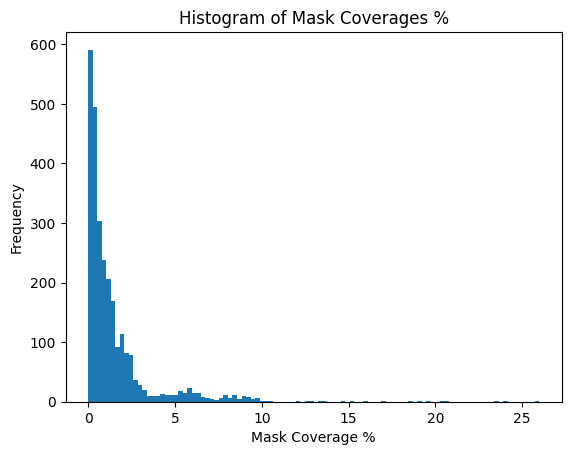

In [8]:
import matplotlib.pyplot as plt

plt.hist(mask_coverages, bins=100)
plt.title('Histogram of Mask Coverages %')
plt.xlabel('Mask Coverage %')
plt.ylabel('Frequency')
plt.show()

In [9]:
print(len(mask_coverages))
print(len(zero_masks))

2729
1


In [10]:
# index = 1000

blend_images = []

for index in tqdm(range(len(scans))):
    green_mask = masks[index].copy()
    green_mask[:, :, 1] = 0
    green_mask[:, :, 2] = 0

    scan = Image.fromarray(scans[index]).convert('RGBA')
    mask = Image.fromarray(green_mask).convert('RGBA')
    blend_image = Image.blend(scan, mask, 0.5)

    blend_images.append(np.array(blend_image))

100%|██████████| 2729/2729 [00:07<00:00, 349.29it/s]


In [11]:
df = pd.DataFrame({"scan": scans, "mask": masks, "blend_image": blend_images, "mask_coverage": mask_coverages})

In [12]:
df.describe()

,mask_coverage
count,2729.000000
mean,1.509914
std,2.337186
min,0.000000
25%,0.302124
50%,0.755692
75%,1.667404
max,25.975007


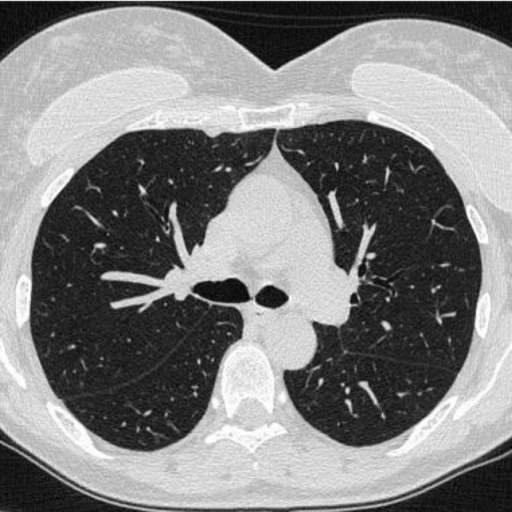

In [13]:
Image.fromarray(list(df.loc[df["mask_coverage"] < 0.00001, "scan"])[0])

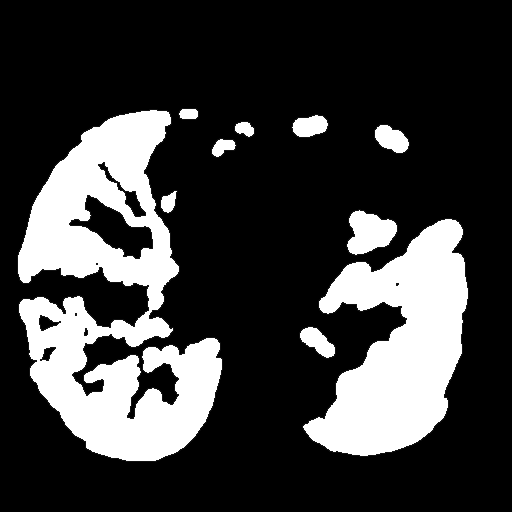

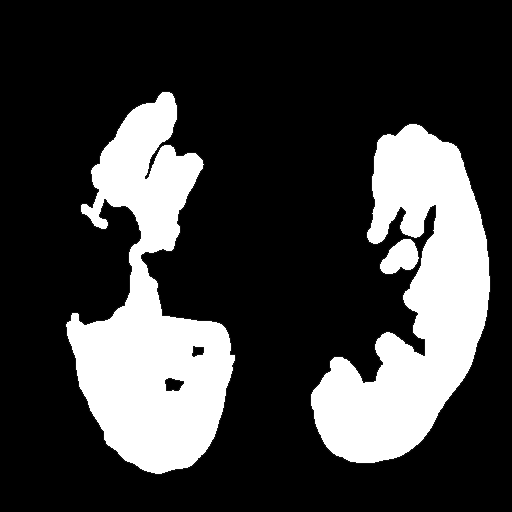

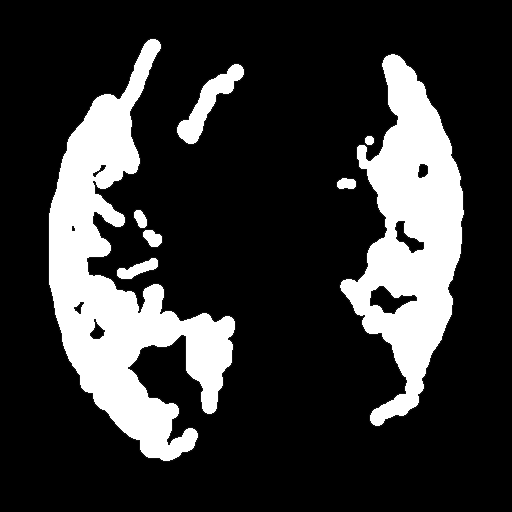

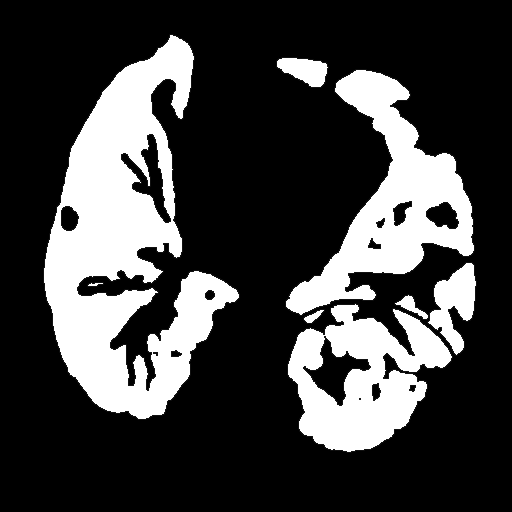

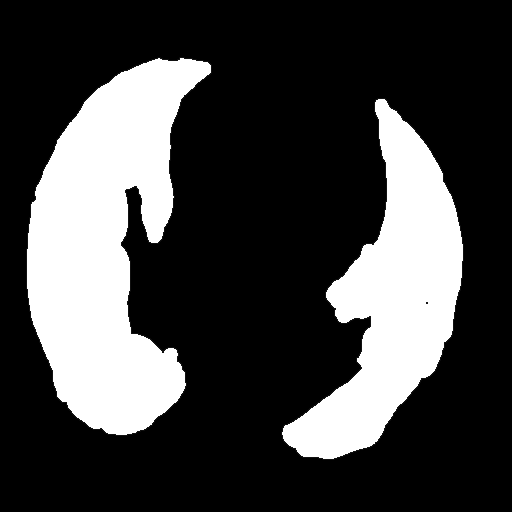

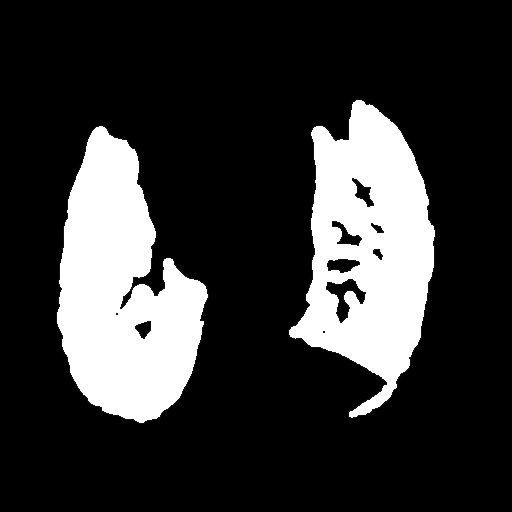

In [14]:
for img in list(df.loc[df["mask_coverage"] > 20, "mask"]):
    display(Image.fromarray(img))

In [15]:
df.iloc[0]

scan             [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...
mask             [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
blend_image      [[[0, 0, 0, 255], [0, 0, 0, 255], [0, 0, 0, 25...
mask_coverage                                            13.711786
Name: 0, dtype: object

# Split

In [16]:
len(df)

2729

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2729 entries, 0 to 2728
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   scan           2729 non-null   object 
 1   mask           2729 non-null   object 
 2   blend_image    2729 non-null   object 
 3   mask_coverage  2729 non-null   float64
dtypes: float64(1), object(3)
memory usage: 85.4+ KB


In [32]:
train_df, test_df = scsplit(
    df, 
    stratify=df["mask_coverage"],
    test_size=0.2,
    train_size=0.8,
    random_state=rs, 
)
val_df, test_df = scsplit(
    test_df, 
    stratify=test_df["mask_coverage"],
    test_size=0.5,
    train_size=0.5,
    random_state=rs, 
)

In [46]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(len(train_df) + len(val_df) + len(test_df))
print(len(df))

(2183, 4)
(273, 4)
(273, 4)
2729
2729


In [39]:
print(train_df["mask_coverage"].mean())
print(val_df["mask_coverage"].mean())
print(test_df["mask_coverage"].mean())

1.412460250260357
1.405046623705071
1.3510609721089457


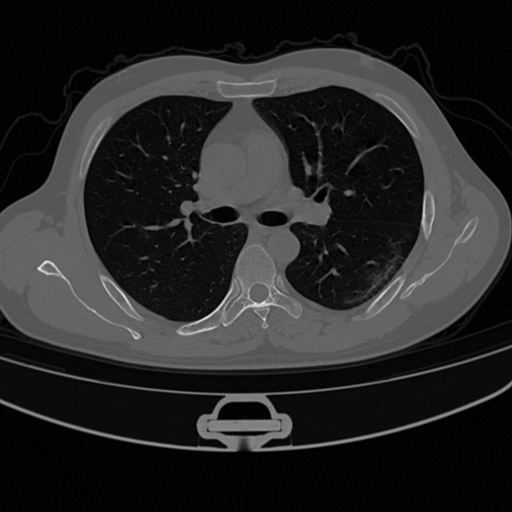

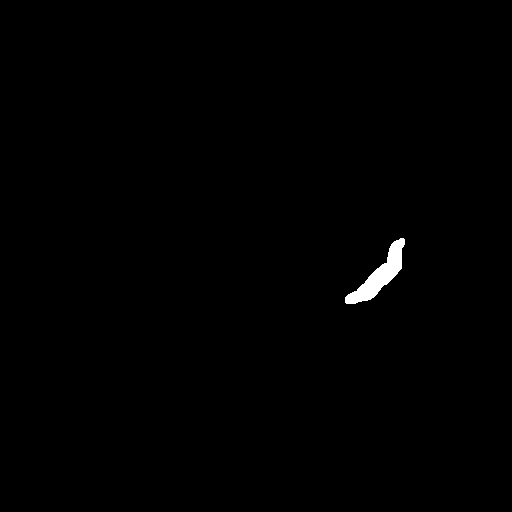

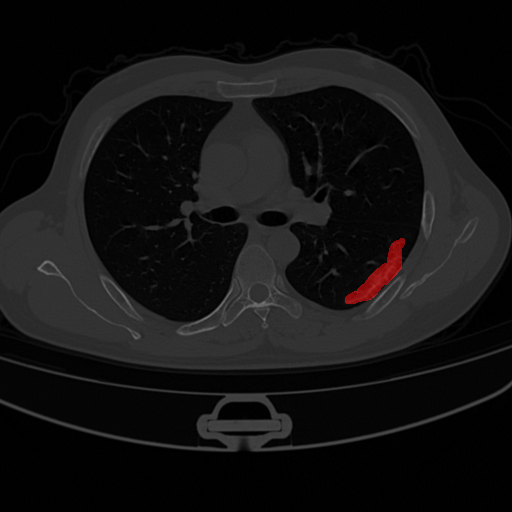

In [45]:
display(Image.fromarray(val_df.iloc[0]["scan"]))
display(Image.fromarray(val_df.iloc[0]["mask"]))
display(Image.fromarray(val_df.iloc[0]["blend_image"]))